In [1]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import itertools
from matplotlib import pyplot as plt
import IPython.display as display
%matplotlib inline

In [2]:
batch_size = 30

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded


In [4]:
class LeNet(nn.Module):
    
    def __init__(self, **kwargs):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

In [6]:
model = LeNet()
if torch.cuda.is_available():
    model.cuda()

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch > 2:
        print('Train Epoch: {} Loss: {:.6f}'.format(
            epoch, loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
for epoch in range(1, 4 + 1):
    train(epoch)
    test(epoch)


Test set: Average loss: 0.8272, Accuracy: 7820/10000 (78%)


Test set: Average loss: 0.3074, Accuracy: 9137/10000 (91%)

Train Epoch: 3 Loss: 0.410110

Test set: Average loss: 0.2159, Accuracy: 9369/10000 (94%)

Train Epoch: 4 Loss: 0.292243

Test set: Average loss: 0.1725, Accuracy: 9495/10000 (95%)



## PCA Reconstruction

In [10]:
dat = train_loader.dataset.train_data.numpy()

In [11]:
dat2 = dat.reshape(dat.shape[0], dat.shape[1]*dat.shape[2])

In [12]:
from sklearn.decomposition import PCA

In [51]:
pc = PCA(n_components=10)
x = pc.fit_transform(dat2)

In [52]:
test = pc.inverse_transform(x)

In [53]:
from ipywidgets import IntSlider, HBox, VBox
from bqplot import pyplot as blt
from bqplot import ColorScale

In [54]:
pc_sc = ColorScale(scheme='Greys')
im_sc = ColorScale(scheme='Greys')

In [55]:
fig_pca = blt.figure(title='Reconstructed')
hmap_pca = blt.heatmap(test[0].reshape(28, 28)[::-1], scales={'color': pc_sc},axes_options={'x': {'visible': False},
                                                                           'y': {'visible': False},
                                                                            'color': {'visible': False}})

In [56]:
fig_img = blt.figure(title='Original')
hmap_img = blt.heatmap(dat[0][::-1], scales={'color': im_sc}, axes_options={'x': {'visible': False},
                                                                           'y': {'visible': False},
                                                                            'color': {'visible': False}})

In [127]:
def plot_10_by_10_images(images, title='Reconstructed Images'):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure(figsize=(12, 10))
    plt.title = title
    images = [image[3:25, 3:25] for image in images]
    #image = np.concatenate(images, axis=1)
    for x in range(1, 11):
        for y in range(1, 11):
            ax = fig.add_subplot(11, 11, 10*(y)+(x))
            ax.matshow(images[10*y+x], cmap = plt.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

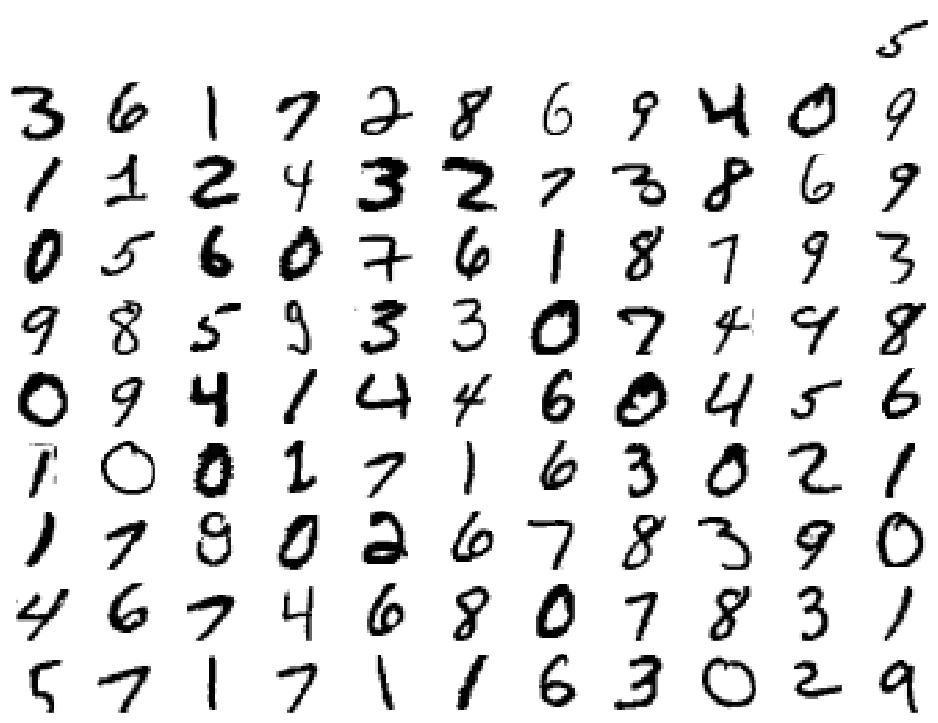

In [128]:
plot_10_by_10_images(dat, title='Original Images')

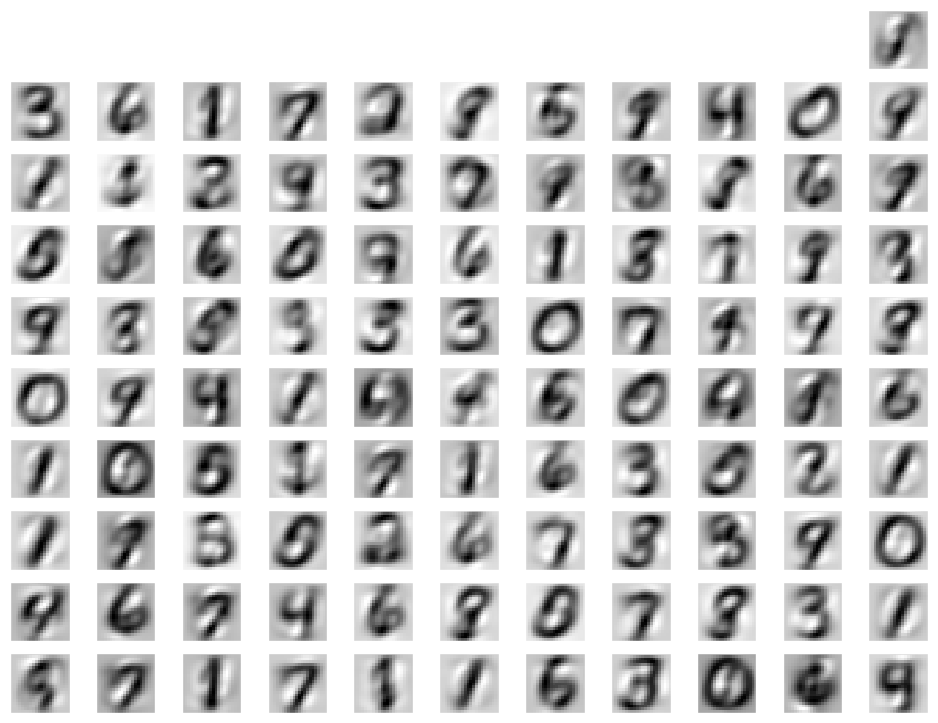

In [129]:
plot_10_by_10_images(test.reshape(test.shape[0], 28, 28))

In [57]:
def changed(value):
    hmap_pca.color = test[slid.value].reshape(28, 28)[::-1]
    hmap_img.color = dat[slid.value][::-1]
    
slid = IntSlider(min=0, max=test.shape[0]-1, value=0, description='Index')
slid.observe(changed, 'value')

In [58]:
VBox([slid, HBox([fig_img, fig_pca])])

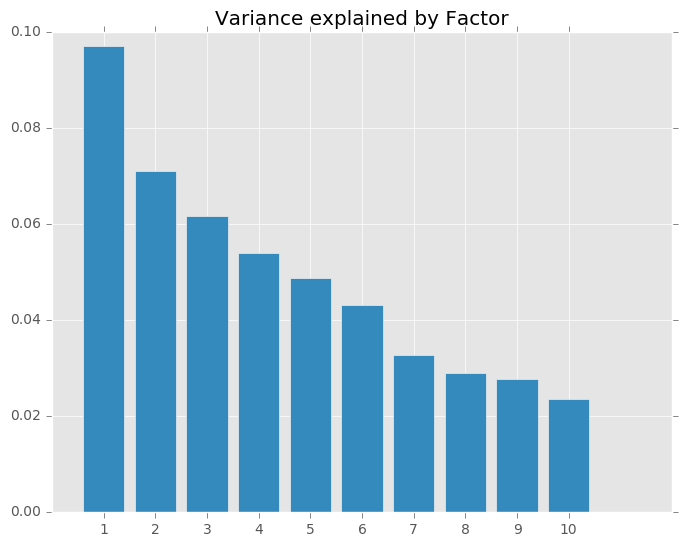

In [77]:
with plt.style.context('ggplot'):
    plt.bar(np.arange(1, 11), pc.explained_variance_ratio_,align='center')
    plt.xticks(np.arange(1, 11))
    plt.title('Variance explained by Factor')

## Autoencoder Reconstruction

In [295]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)

    def forward(self, x):
        x = x.view(-1, 784)
        return F.relu(self.fc2(F.relu(self.fc1(x))))

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 784)
        
    def forward(self, x):
        return F.relu(self.fc2(F.relu(self.fc1(x))))

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = Encoder()
        self.fc2 = Decoder()

    def forward(self, x):
        return self.fc2(self.fc1(x))

model = AutoEncoder()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [266]:
ss=train_loader.dataset.train_data[0]

In [267]:
criterion = torch.nn.MSELoss(size_average=True)

In [268]:
def train(epoch):
    model.train()
    optimizer.zero_grad()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(data).float()
        output = model(data)
        loss = criterion.forward(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} Loss: {:.6f}'.format(
        epoch, loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(data)
        output = model(data)
        test_loss += criterion(output, target).data[0]

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('Test Loss: {} Loss: {:.6f}'.format(
        epoch, test_loss))

In [ ]:
for epoch in range(1, 100):
    train(epoch)
    test(epoch)

Final Test Error: 0.252792

In [280]:
def plot_10_by_10_images(images, title='Reconstructed Images', model=None, train_loader=None):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure(figsize=(12, 10))
    if model is None:
        plt.title = title
        images = [image[3:25, 3:25] for image in images]
    else:
        plt.title = 'Original Images'
    #image = np.concatenate(images, axis=1)
    for x in range(1, 11):
        for y in range(1, 11):
            ax = fig.add_subplot(11, 11, 10*(y)+(x))
            if model is None:
                ax.matshow(images[10*y+x], cmap = plt.cm.binary)
            else:
                img = model(Variable(train_loader.dataset.train_data[10*y+x]).float()).data.numpy().reshape(28, 28)
                ax.matshow(img, cmap = plt.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

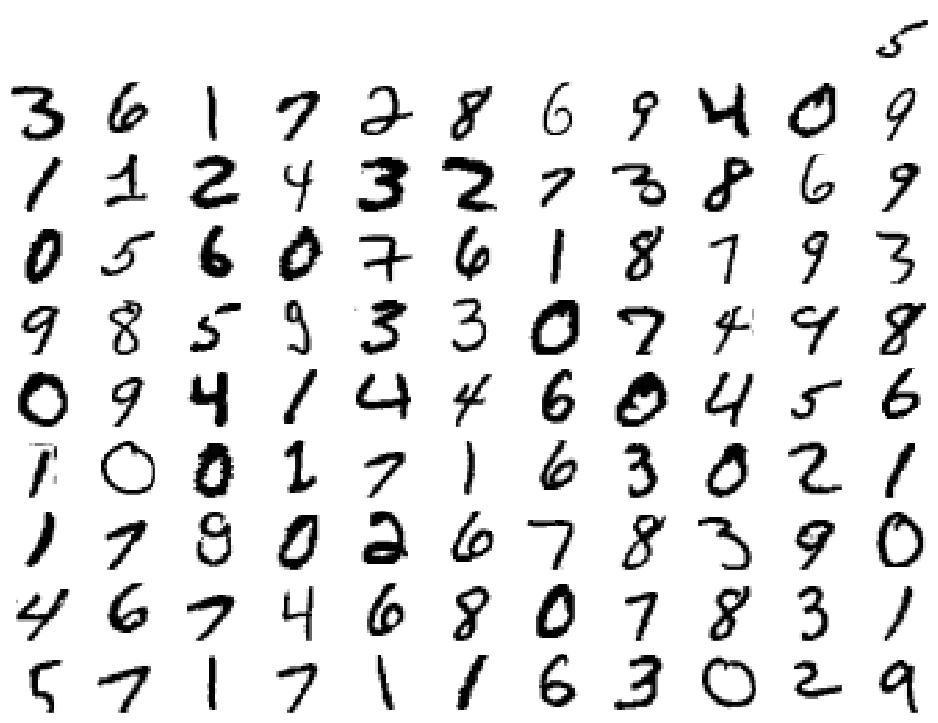

In [281]:
plot_10_by_10_images(dat)

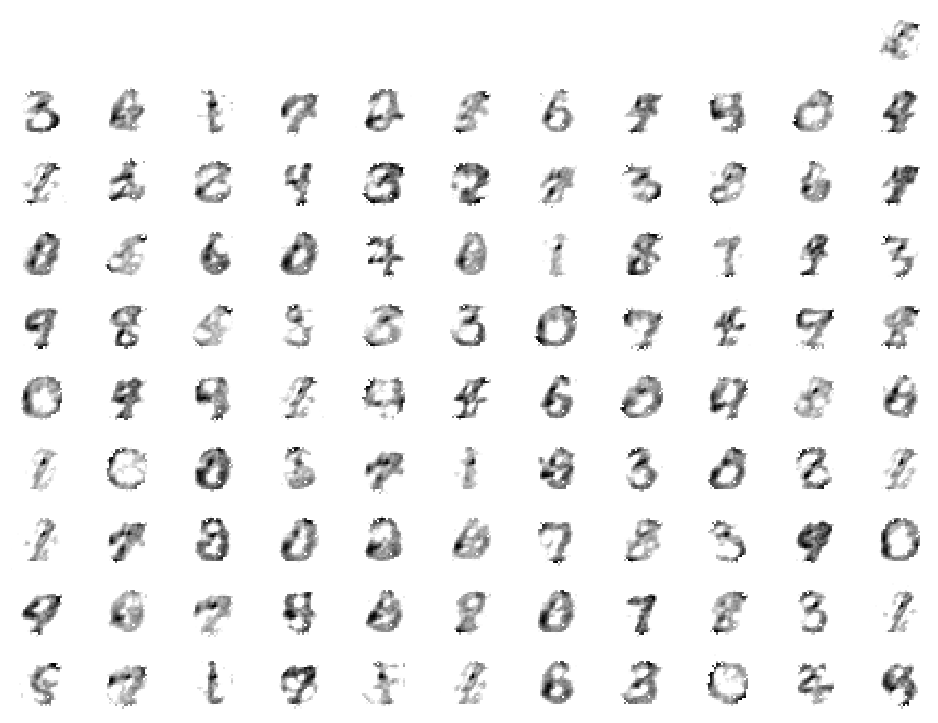

In [282]:
plot_10_by_10_images(None, model=model, train_loader=train_loader)

## Denoising Autoencoder

In [308]:
def train(epoch):
    model.train()
    optimizer.zero_grad()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data + 0.5 * torch.randn(data.size())), Variable(data).float()
        output = model(data)
        loss = criterion.forward(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} Loss: {:.6f}'.format(
        epoch, loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data + 0.5 * torch.randn(data.size()),
                                volatile=True), Variable(data)
        output = model(data)
        test_loss += criterion(output, target).data[0]

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('Test Loss: {} Loss: {:.6f}'.format(
        epoch, test_loss))

In [309]:
ss=train_loader.dataset.train_data[0]

In [310]:
criterion = torch.nn.MSELoss(size_average=True)

In [311]:
model = AutoEncoder()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(1, 100):
    train(epoch)
    test(epoch)

In [318]:
noise_dat = dat + 50 * np.random.randn(*dat.shape)

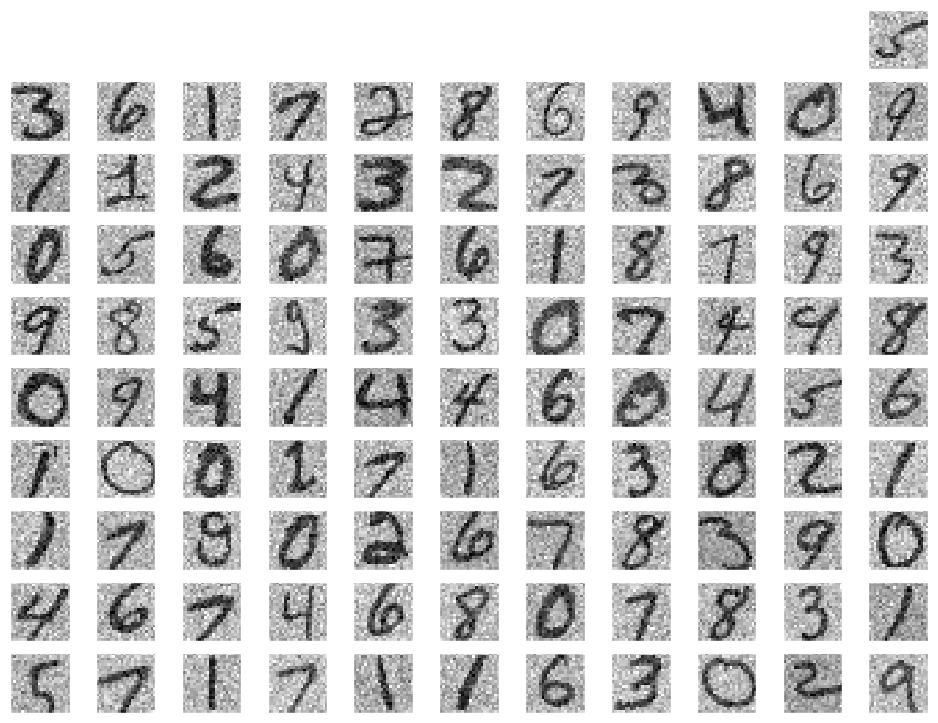

In [319]:
plot_10_by_10_images(noise_dat)

In [323]:
def plot_10_by_10_images_noise(images, title='Reconstructed Images', model=None, train_loader=None):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure(figsize=(12, 10))
    if model is None:
        plt.title = title
        images = [image[3:25, 3:25] for image in images]
    else:
        plt.title = 'Original Images'
    #image = np.concatenate(images, axis=1)
    for x in range(1, 11):
        for y in range(1, 11):
            ax = fig.add_subplot(11, 11, 10*(y)+(x))
            if model is None:
                ax.matshow(images[10*y+x], cmap = plt.cm.binary)
            else:
                shp = train_loader.dataset.train_data[10*y+x].size()
                img = model(Variable(train_loader.dataset.train_data[10*y+x].float() + 0.5 * torch.randn(shp)
                                    ).float()).data.numpy().reshape(28, 28)
                ax.matshow(img, cmap = plt.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

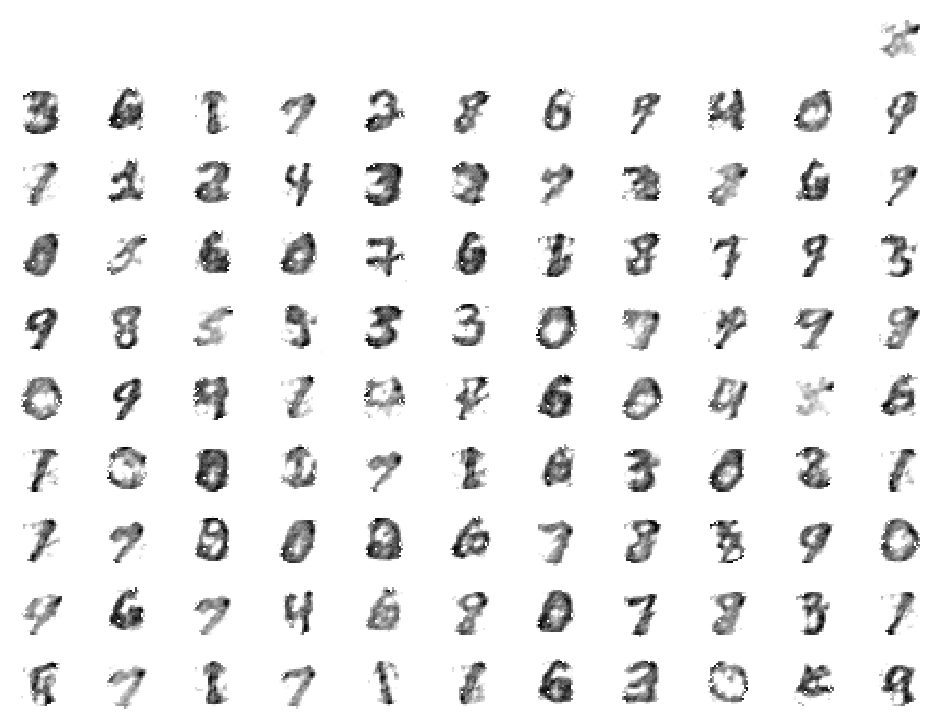

In [324]:
plot_10_by_10_images_noise(None, model=model, train_loader=train_loader)

## Variational Auto-encoder

## Generative Adversarial Network

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [7]:
discriminator = Discriminator()
generator = Generator()

In [8]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [9]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [10]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [11]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

KeyboardInterrupt: 

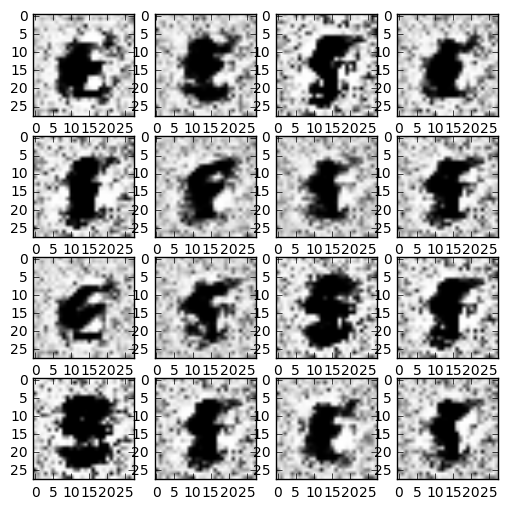

In [12]:
# set number of epochs and initialize figure counter
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].axis('off')


num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images)
        real_labels = Variable(torch.ones(images.size(0)))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))